# Julia processing notebook

1. Take resulting lc csv file (see Python notebook) and do an FFT

In [34]:
using DataFrames
testFile = "mos1_lc_src_0310keV_bin1_35.csv"

In [55]:
function csv2DF(csvFile)
    raw = readlines(csvFile)
    noHead = raw[5:end]
    df = DataFrame([Float64,Float64,Float64],[:rate,:error,:time], length(noHead))
    for i=1:length(noHead)
        row = noHead[i]
        rowSplit = split(row) #break up into index, rate, error, time entries
        for j=2:length(rowSplit) #skip index column
            el = strip(rowSplit[j]) #get rid of white space
            floatVal = parse(Float64,el[1:end-1]) #convert to float
            df[i,j-1] = floatVal #end-1 because want to get rid of comma
        end
    end
    return df
end

csv2DF (generic function with 1 method)

In [115]:
csvDF = csv2DF(testFile)

,rate,error,time
,Float64,Float64,Float64
1,0.0,0.0,6.57153e8
2,0.0,0.0,6.57153e8
3,0.0,0.0,6.57153e8
4,0.0,0.0,6.57153e8
5,0.0,0.0,6.57153e8
6,0.0,0.0,6.57153e8
7,0.0,0.0,6.57153e8
8,0.0,0.0,6.57153e8
9,0.0,0.0,6.57153e8


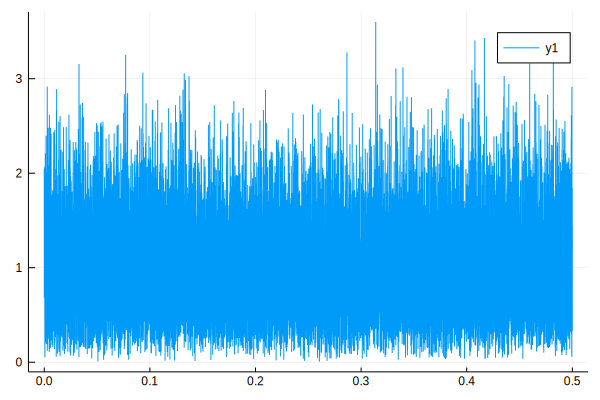

In [116]:
using FFTW, Plots
fTest=fft(csvDF.rate[:]) #rate column is really counts (counts/s * recorded each sec)
fTest=fTest[2:end] #discard Nyquist
fTest=fTest[1:Int(floor(length(fTest)/2))] #take just half and round down
fTest=abs.(fTest) #this is the square magnitude I think...
avgPow=mean(fTest)
fTest=fTest./avgPow
dt=test.time[end]-test.time[1]
xAx=[i/dt for i=1:length(fTest)] #frequency
fftDF = DataFrame(f=xAx,pow=fTest)
plot(xAx,fTest)

In [113]:
function genFFTDF(df)
    fftOut=fft(df.rate[:]) #rate is really counts (counts/s recorded every sec)
    fftOut=fftOut[2:end] #get rid of Nyqhuist
    fftOut=fftOut[1:Int(floor(length(fftOut)/2))] #take half (rounding midpoint down if needed)
    fftOut=abs.(fftOut) #square magnitude
    avgPow=mean(fftOut)
    fftOut=fftOut./avgPow #normalize
    dt=df.time[end]-df.time[1]
    freq=[i/dt for i=1:length(fftOut)] #freq(i) = bin#/totalTime
    fftDF=DataFrame(f=freq,pow=fftOut)
    return fftDF
end

genFFTDF (generic function with 1 method)

In [114]:
fftDF=genFFTDF(test)

,f,pow
,Float64,Float64
1,2.7684e-5,2.04729
2,5.53679e-5,0.698151
3,8.30519e-5,0.684235
4,0.000110736,1.59262
5,0.00013842,1.53991
6,0.000166104,1.14432
7,0.000193788,1.54444
8,0.000221472,1.45353
9,0.000249156,1.33227


2. synthesize all info into metafile

In [122]:
#obsid_cam, srcnum, startdate, exptime, ra, dec, freq, power
#create master list akin to CHANDRA file above power threshold
using Formatting, Statistics
function createAllInfo(powCutoff,obsid,cam,srcReg,srcNum,startdate,ra,dec,fitsDF,fftInfo)
    outFile = string("xmm.fftinfo.all",powCutoff)
    exptime = fitsDF.time[end]-fitsDF.time[1]
    obsidCam = string(obsid,"_",cam)
    srcRegNum = string(srcReg,"_",srcNum)
    open(outFile,"w") do file
        for i=1:length(fftInfo.pow[:])
            if fftInfo.pow[i] >= powCutoff
                freq = fftInfo.f[i]
                power = fftInfo.pow[i]
                write(file,"$obsidCam,$srcRegNum,$startdate,$exptime,$ra,$dec,$freq,$power\n")
            end
        end
    end
end
        
    
    

createAllInfo (generic function with 2 methods)

In [123]:
obsid = "0810880201"
cam = "M1"
srcNum = "3"
ra = "57"
dec = "23.234"
startdate = "1234"

createAllInfo(2,obsid,cam,srcNum,ra,dec,csvDF,fftDF)

In [125]:
function getCMDArgs() #needed to help interface with Python set up
    argList = ARGS
    obsid = argsList[1]
    cam = argsList[2]
    srcReg = argsList[3]
    srcNum = argsList[4]
    ra = argsList[5]
    dec = argsList[6]
    startdate = argsList[7]
    abin = argsList[8]
    arange = argsList[9]
    powCutoff = Int(argsList[10])
    return obsid,cam,srcReg,srcNum,ra,dec,startdate,abin,arange,powCutoff
end

getCMDArgs (generic function with 1 method)

In [126]:
using CSV
function saveFFT(obsid,cam,srcReg,srcNum,fftDF)
    exportFile=join([obsid,cam,srcReg,srcNum,"FFT"],"_")
    exportFile=string(exportFile,".csv")
    CSV.write(exportFile,fftDF)
end

saveFFT (generic function with 1 method)

In [ ]:
#master program to be called by python script
obsid,cam,srcReg,srcNum,ra,dec,startdate,abin,arange,powCutoff = getCMDArgs() 
infile = join([obsid,cam,arange,"lc",srcReg,srcNum,string(arange,"keV"),string("bin",abin)],"_")
infile = string(infile,".csv")
csvDF = csv2DF(infile)
fftDF = genFFTDF(csvDF)
saveFFT(obsid,cam,srcNum,)
createAllInfo(powCutoff,obsid,cam,srcNum,startdate,ra,dec,csvDF,fftDF)

In [128]:
a = 5
b = 6
c = join([

"5_6"

In [147]:
using CSV
function obsidIterator(obsidFolder, listDestFolder)
    """iterate through all obsids in a folder containing raw PPS products"""
    """return all obsids of interest and all source region file names"""
    curdir = pwd()
    
    try cd(obsidFolder)
        
        outFile = string(listDestFolder,"/obsids.txt")
        println(outFile)
        run(`ls` |> outFile)
        obsids = CSV.read(outfile)
        for obsid in obsids
            ppsPath = string(obsidFolder,"/",obsid,"/PPS")
            cd(ppsPath)
            outFile = string(listDestFolder,"/",obsid)
            run(`ls '*'SRCREG'*'` |> outFile)
        end
    catch
        print("OBSID folder does not exist as entered")
    end
    cd(curdir) #go back to old directory
end

obsidIterator (generic function with 1 method)

In [148]:
obsidFolder = "/home/kirk/Documents/research/XMM_Newton/obsids"
listDestFolder = "/home/kirk/Documents/research/XMM_Newton/python_xmmscripts/pipeline"
obsidIterator(obsidFolder,listDestFolder)

/home/kirk/Documents/research/XMM_Newton/python_xmmscripts/pipeline/obsids.txt
OBSID folder does not exist as entered

In [149]:
cd(obsidFolder)
outFile = string(listDestFolder,"/obsids.txt")
run(`ls` |> outFile)

MethodError: MethodError: objects of type String are not callable